In [63]:
import jax
import jax.numpy as np
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)

In [64]:
def fig_config():
    fig, ax = plt.subplots(1, 1, figsize=(8., 8,))
    ax.set_aspect('equal')
    ax.set_xlim(-1.8, 3.2)
    ax.set_ylim(-0.7, 4.3)
    return fig, ax

In [65]:
vert_gt = np.array([
    [0.0, 0.0],
    [np.sqrt(2), 0],
    [np.sqrt(2) + 1, 1],
    [np.sqrt(2) + 1, np.sqrt(2) + 1],
    [np.sqrt(2), np.sqrt(2) + 2],
    [0.0, np.sqrt(2) + 2],
    [-1, np.sqrt(2) + 1],
    [-1, 1]
])

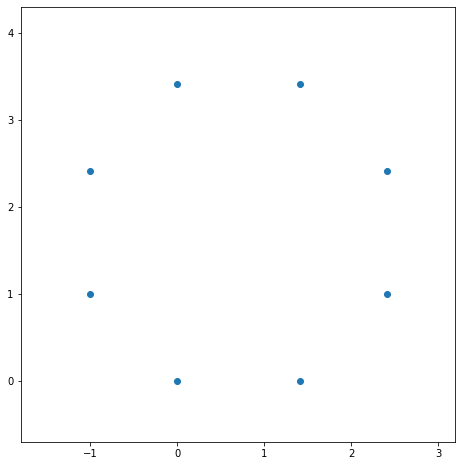

In [66]:
fig, ax = fig_config()
for vt in vert_gt:
    ax.plot(vt[0], vt[1], linestyle='', marker='o', color='C0')

In [67]:
edge_list = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 0],
    [0, 5],
    [1, 4],
    [2, 7],
    [3, 6]
], dtype=int)

In [68]:
vert_gt[edge_list[0]]

DeviceArray([[0.       , 0.       ],
             [1.4142135, 0.       ]], dtype=float32)

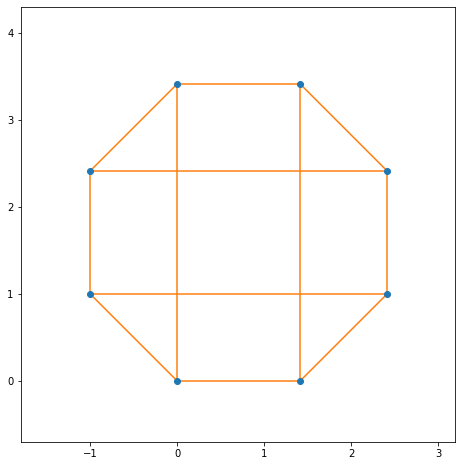

In [69]:
fig, ax = fig_config()
for ed in edge_list:
    ax.plot(vert_gt[ed][:,0], vert_gt[ed][:,1], linestyle='-', color='C1')
for vt in vert_gt:
    ax.plot(vt[0], vt[1], linestyle='', marker='o', color='C0')
plt.show()

In [70]:
def obs_func(v1, v2):
    obs = np.linalg.norm(v1 - v2)
    return obs

obs_dict = lambda params: obs_func(params['v1'], params['v2'])
obs_jac_dict = jacrev(obs_dict)

print(obs_func(np.ones(2), np.zeros(2)))
print(obs_dict({'v1': np.ones(2), 'v2': np.zeros(2)}))
print(obs_jac_dict({'v1': np.ones(2), 'v2': np.ones(2) * 0.5}))

1.4142135
1.4142135
{'v1': DeviceArray([0.7071067, 0.7071067], dtype=float32), 'v2': DeviceArray([-0.7071067, -0.7071067], dtype=float32)}


In [71]:
obs_list = []
for ed in edge_list:
    v1 = vert_gt[ed[0]]
    v2 = vert_gt[ed[1]]
    obs = obs_func(v1, v2) + jax.random.normal(key) * 0.2 # 0.2 is standard deviation
    obs_list.append(obs)
obs_list = np.array(obs_list)
obs_list

DeviceArray([1.3730451, 1.3730452, 1.3730452, 1.3730452, 1.3730451,
             1.3730451, 1.3730452, 1.3730451, 3.3730452, 3.3730452,
             3.3730452, 3.3730452], dtype=float32)

In [72]:
def objective(vertices):
    v0 = vertices[0]
    obj = (1 / 0.02) * np.linalg.norm(v0) ** 2
    for i in range(obs_list.shape[0]):
        obs = obs_list[i]
        ed = edge_list[i]
        vi = vertices[ed[0]]
        vj = vertices[ed[1]]
        obj += (1 / 0.2) * (obs - obs_func(vi, vj)) ** 2
    return obj

In [73]:
vert_k = vert_gt + jax.random.normal(key, vert_gt.shape) * 0.1

In [74]:
def obs_jac_whole(vertices):
    res = np.zeros((obs_list.shape[0]+1, vertices.shape[0] * vertices.shape[1]))
    
    v0 = vertices[0]
    dobj_k = obs_jac_dict({'v1': v0, 'v2': np.zeros(2)})
    res = jax.ops.index_update(res, jax.ops.index[0, 0:2], dobj_k['v1'])
    
    for k in range(obs_list.shape[0]):
        ed = edge_list[k]
        vi = vertices[ed[0]]
        vj = vertices[ed[1]]
        dobj_k = obs_jac_dict({'v1': vi, 'v2': vj})
        
        res = jax.ops.index_update(res, jax.ops.index[k+1, 2*ed[0]:2*ed[0]+2], dobj_k['v1'])
        res = jax.ops.index_update(res, jax.ops.index[k+1, 2*ed[1]:2*ed[1]+2], dobj_k['v2'])
        
    return res

(13, 16)


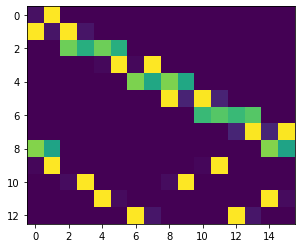

In [75]:
res = obs_jac_whole(vert_k)
res_binary = (np.abs(res) > 0).astype(float)
print(res.shape)
plt.imshow(np.abs(res), aspect='equal')

In [76]:
# res = np.ones((3, 5))
q, r = np.linalg.qr(res)

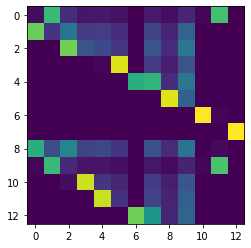

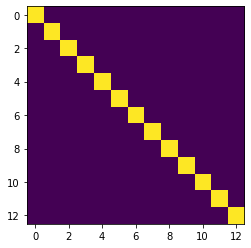

In [77]:
plt.imshow(np.abs(q), aspect='equal')
plt.show()
plt.imshow(q.T.dot(q), aspect='equal')
plt.show()

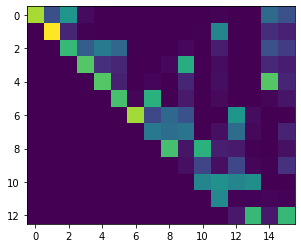

In [78]:
plt.imshow(np.abs(r), aspect='equal')

In [79]:
(np.abs(res-q.dot(r)) < 1e-06).astype(int)

DeviceArray([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],            dtype=int32)